In [2]:
import librosa
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import scipy.signal as sps

# Prediction and Quantization
A simple signal processing system and its evaluation using commonly found metrics in signal processing and communications.

Parts
1. Using an IIR filter for "one-step-ahead" prediction
2. Using a quantizer to discretize sample values
3. Putting it all together
4. Bonus: Comparing performance

In [2]:
def signal_gen(frequency, amplitude, phase_degrees, duration, Fs):
    phase = phase_degrees * np.pi/180
    t  = np.arange(0,duration, 1/Fs) # X axis: Time & Samples
    return amplitude*np.sin(2*np.pi*frequency*t+phase), t

def dB(voltage):
    return 20 * np.log10(voltage)

### Example Predictor

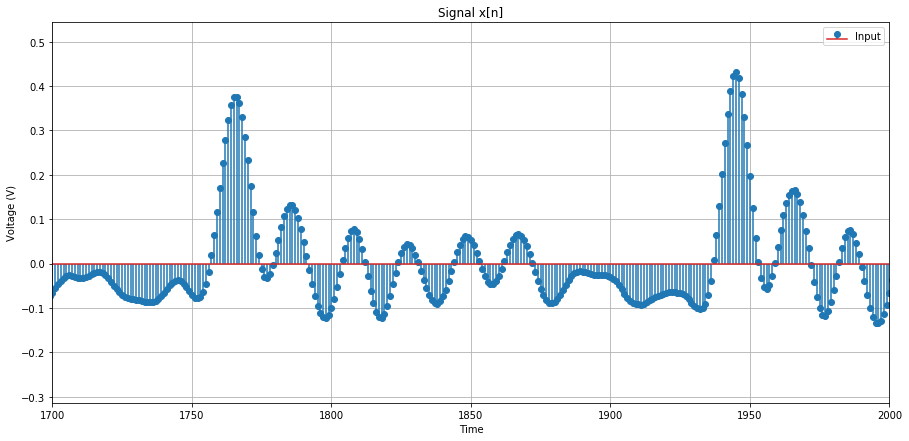

In [18]:
n= [-2,-1,0,1,2,3,4,5,6,7,8,9]
x= [0,0,1.0,-1.0,0.0,2.0,1.0,-1.0,-2.0,0.0,1.0,0.0]

x, sr = librosa.load('snip.wav')
a = librosa.lpc(x, 2)

numerator = -1 * np.delete(a, 0)
denominator = [1]
x_hat = sps.lfilter(numerator, denominator, x) 
x_hat = np.append(0,x_hat[0:-1])
err = x - x_hat

# Graph
plt.figure('position', [15,7])
# plt.subplots_adjust(hspace = .5)

# plt.subplot(2,1,1)
plt.title('Signal x[n]')
plt.stem(x, label='Input', use_line_collection=True)
plt.ylabel('Voltage (V)')
plt.xlabel('Time')
plt.xlim(1700,2000)
plt.grid()
plt.legend()

In [4]:
librosa.load?

### Using an IIR filter for "one-step-ahead" prediction

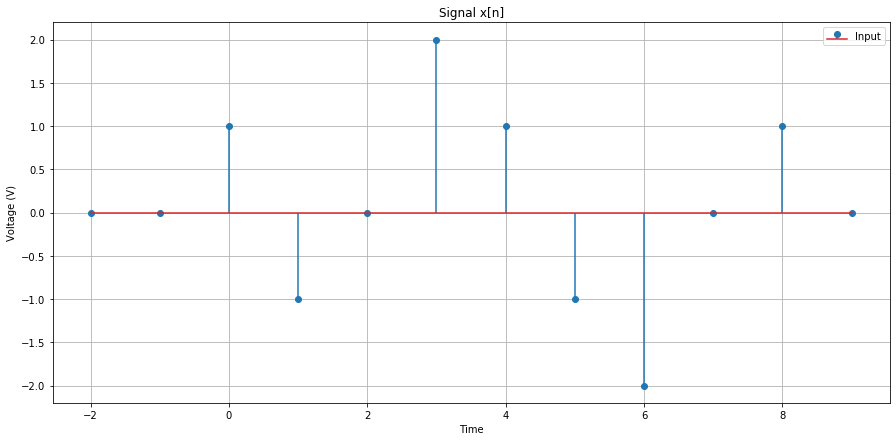

In [3]:
n= [-2,-1,0,1,2,3,4,5,6,7,8,9]
x= [0,0,1.0,-1.0,0.0,2.0,1.0,-1.0,-2.0,0.0,1.0,0.0]


# Graph
plt.figure('position', [15,7])
# plt.subplots_adjust(hspace = .5)

# plt.subplot(2,1,1)
plt.title('Signal x[n]')
plt.stem(n, x, label='Input', use_line_collection=True)
plt.ylabel('Voltage (V)')
plt.xlabel('Time')
plt.grid()
plt.legend()